In [4]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, when, count, expr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
# Define input and output paths
input_path = "gs://my-bigdata-project-es/trusted/trusted_itineraries.parquet"

# Load the data
sdf = spark.read.parquet(input_path)

In [6]:
 # Drop rows with missing values
sdf_cleaned = sdf.dropna()  

In [7]:
# Calculate quantiles (Q1 and Q3) using Spark's SQL expressions
quantiles = sdf_cleaned.approxQuantile("totalFare", [0.25, 0.75], 0.01)
q1, q3 = quantiles[0], quantiles[1]
iqr = q3 - q1

# Define lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the DataFrame to exclude outliers
sdf_trimmed = sdf_cleaned.filter((col("totalFare") >= lower_bound) & (col("totalFare") <= upper_bound))

24/12/04 19:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1398.9 KiB
24/12/04 19:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1400.0 KiB


In [8]:
# Define feature columns for prediction
feature_columns = [
    "totalTravelDistance", "DaysInAdvance", 
    "FlightDayOfWeek", "FlightMonth", "seatsRemaining"
]

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
transformed_sdf = assembler.transform(sdf_trimmed)

# Split into train and test datasets
train_data, test_data = transformed_sdf.randomSplit([0.8, 0.2], seed=42)

# Train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="totalFare")
model = lr.fit(train_data)

24/12/04 19:48:58 WARN Instrumentation: [f3779111] regParam is zero, which might cause numerical instability and overfitting.
24/12/04 19:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1492.4 KiB
24/12/04 19:50:47 WARN DAGScheduler: Broadcasting large task binary with size 1493.5 KiB
24/12/04 19:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1481.5 KiB
24/12/04 19:52:32 WARN DAGScheduler: Broadcasting large task binary with size 1482.6 KiB


In [9]:
# Make predictions
predictions = model.transform(test_data)

# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="totalFare", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Model RMSE: {rmse}")

24/12/04 19:52:32 WARN DAGScheduler: Broadcasting large task binary with size 1482.1 KiB


Model RMSE: 94.02066273631014


24/12/04 19:54:13 WARN DAGScheduler: Broadcasting large task binary with size 1483.2 KiB


In [10]:
sdf.columns

['legId',
 'searchDate',
 'flightDate',
 'StartingAirport',
 'DestinationAirport',
 'fareBasisCode',
 'travelDuration',
 'elapsedDays',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDepartureTimeEpochSeconds',
 'segmentsDepartureTimeRaw',
 'segmentsArrivalTimeEpochSeconds',
 'segmentsArrivalTimeRaw',
 'segmentsArrivalAirportCode',
 'segmentsDepartureAirportCode',
 'SegmentsAirlineName',
 'segmentsAirlineCode',
 'DaysInAdvance',
 'FlightDayOfWeek',
 'FlightMonth',
 'DepartureHour',
 'Route',
 'SeatsRemainingCategory',
 'StartingAirport_Index',
 'DestinationAirport_Index',
 'fareBasisCode_Index',
 'SegmentsAirlineName_Index',
 'Route_Index',
 'SeatsRemainingCategory_Index',
 'StartingAirport_OneHot',
 'DestinationAirport_OneHot',
 'fareBasisCode_OneHot',
 'SegmentsAirlineName_OneHot',
 'Route_OneHot',
 'SeatsRemainingCategory_OneHot',
 'totalTravelDistance_Vector',
 'totalTravelDistance_Scaled']

24/12/04 19:56:16 WARN DAGScheduler: Broadcasting large task binary with size 1472.0 KiB


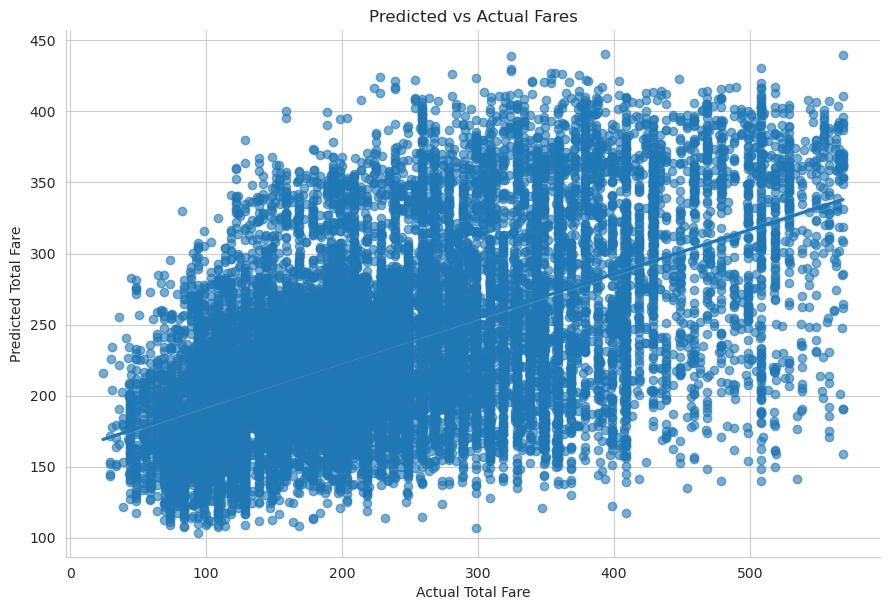

In [12]:
# Take a random sample of predictions for visualization
sampled_predictions = predictions.sample(fraction=0.005, seed=42) 

# Convert the sampled data to Pandas for visualization
predictions_pd = sampled_predictions.select("totalFare", "prediction").toPandas()

# Create the Actual vs. Predicted plot
sns.set_style("whitegrid")
sns.lmplot(
    x="totalFare", 
    y="prediction", 
    data=predictions_pd, 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.6}
)
plt.title("Predicted vs Actual Fares")
plt.xlabel("Actual Total Fare")
plt.ylabel("Predicted Total Fare")
plt.savefig("predicted_vs_actual.png")
plt.show()

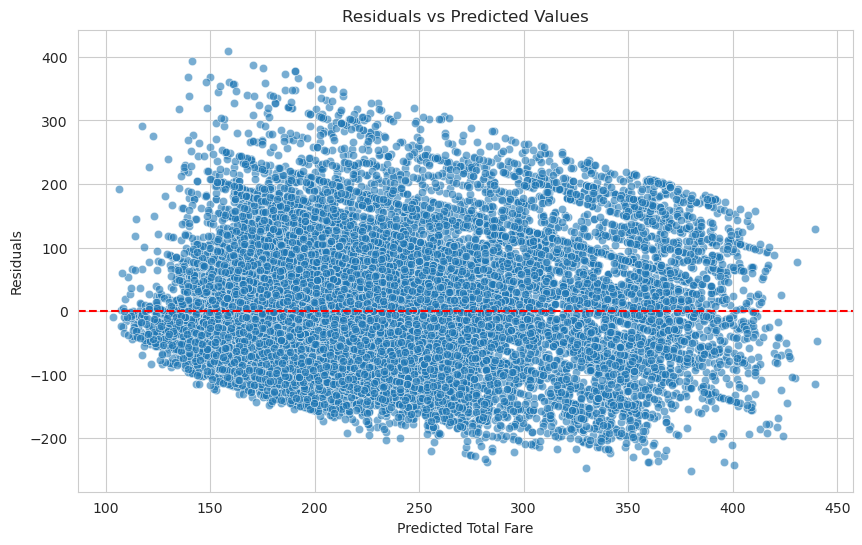

In [13]:
# Residual Plot
predictions_pd["residual"] = predictions_pd["totalFare"] - predictions_pd["prediction"]
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="residual", data=predictions_pd, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Total Fare")
plt.ylabel("Residuals")
plt.savefig("residual_plot.png")

24/12/04 19:58:10 WARN DAGScheduler: Broadcasting large task binary with size 1380.8 KiB
24/12/04 19:59:32 WARN YarnAllocator: Container from a bad node: container_1733337067437_0004_01_000001 on host: cluster-51ee-m.us-central1-f.c.applied-card-433613-g5.internal. Exit status: 143. Diagnostics: [2024-12-04 19:59:32.368]Container killed on request. Exit code is 143
[2024-12-04 19:59:32.369]Container exited with a non-zero exit code 143. 
[2024-12-04 19:59:32.369]Killed by external signal
.
24/12/04 19:59:32 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Container from a bad node: container_1733337067437_0004_01_000001 on host: cluster-51ee-m.us-central1-f.c.applied-card-433613-g5.internal. Exit status: 143. Diagnostics: [2024-12-04 19:59:32.368]Container killed on request. Exit code is 143
[2024-12-04 19:59:32.369]Container exited with a non-zero exit code 143. 
[2024-12-04 19:59:32.369]Killed by external signal
.
24/12/04 19:59:32 ER

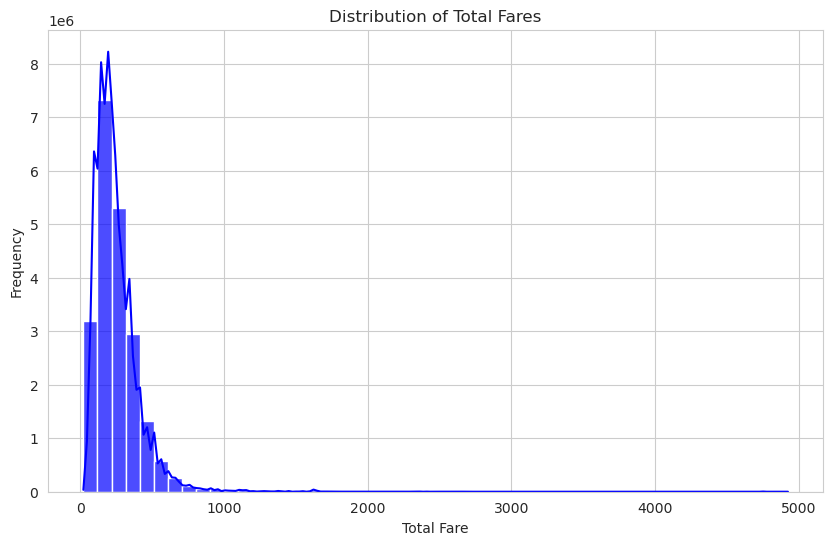

In [14]:
# Distribution of Fares
fare_distribution = sdf_cleaned.select("totalFare").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(fare_distribution["totalFare"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("Distribution of Total Fares")
plt.xlabel("Total Fare")
plt.ylabel("Frequency")
plt.savefig("fare_distribution.png")

24/12/04 20:01:06 WARN Instrumentation: [3e0f4783] regParam is zero, which might cause numerical instability and overfitting.
24/12/04 20:01:06 WARN DAGScheduler: Broadcasting large task binary with size 1492.4 KiB
24/12/04 20:03:05 WARN DAGScheduler: Broadcasting large task binary with size 1493.5 KiB
24/12/04 20:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1481.5 KiB
24/12/04 20:04:54 WARN DAGScheduler: Broadcasting large task binary with size 1482.6 KiB
/tmp/ipykernel_22301/4197081058.py:16: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")



Feature Importance:
               Feature  Importance
0  totalTravelDistance    0.084240
1        DaysInAdvance   -0.549022
4       seatsRemaining   -1.030277
2      FlightDayOfWeek   -3.196177
3          FlightMonth  -12.255376


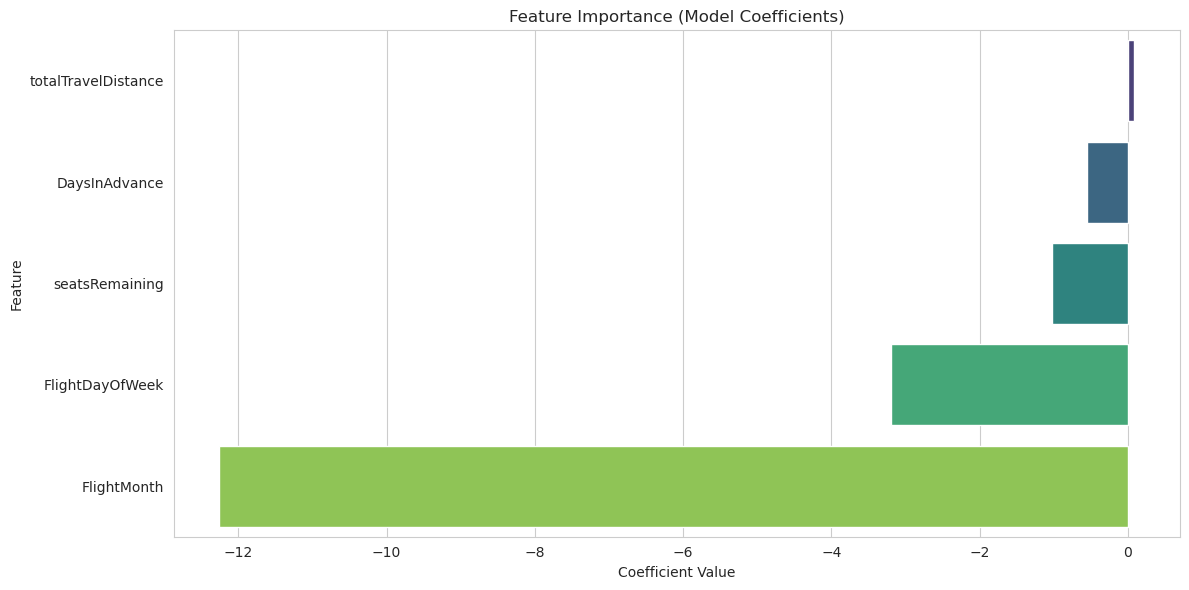

In [15]:
model = lr.fit(train_data)

# Feature importance based on coefficients
coefficients = model.coefficients.toArray()
feature_names = feature_columns  
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance (Model Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

24/12/04 20:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1414.0 KiB
24/12/04 20:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1351.9 KiB
24/12/04 20:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1354.2 KiB
24/12/04 20:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1348.3 KiB


Text(0, 0.5, 'Average Fare')

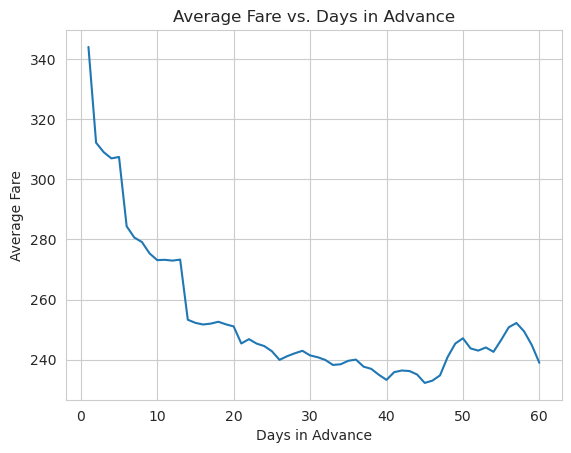

In [16]:
# DaysInAdvance and totalFare
days_advance_df = (
    sdf_cleaned.groupBy("DaysInAdvance")
    .agg({"totalFare": "avg"})
    .withColumnRenamed("avg(totalFare)", "AverageFare")
    .orderBy("DaysInAdvance")
    .toPandas()
)

# Line plot
sns.lineplot(data=days_advance_df, x="DaysInAdvance", y="AverageFare")
plt.title("Average Fare vs. Days in Advance")
plt.xlabel("Days in Advance")
plt.ylabel("Average Fare")

24/12/04 20:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1380.9 KiB
24/12/04 20:10:51 WARN YarnAllocator: Container from a bad node: container_1733337067437_0004_01_000002 on host: cluster-51ee-m.us-central1-f.c.applied-card-433613-g5.internal. Exit status: 143. Diagnostics: [2024-12-04 20:10:51.827]Container killed on request. Exit code is 143
[2024-12-04 20:10:51.827]Container exited with a non-zero exit code 143. 
[2024-12-04 20:10:51.828]Killed by external signal
.
24/12/04 20:10:51 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container from a bad node: container_1733337067437_0004_01_000002 on host: cluster-51ee-m.us-central1-f.c.applied-card-433613-g5.internal. Exit status: 143. Diagnostics: [2024-12-04 20:10:51.827]Container killed on request. Exit code is 143
[2024-12-04 20:10:51.827]Container exited with a non-zero exit code 143. 
[2024-12-04 20:10:51.828]Killed by external signal
.
24/12/04 20:10:51 ER

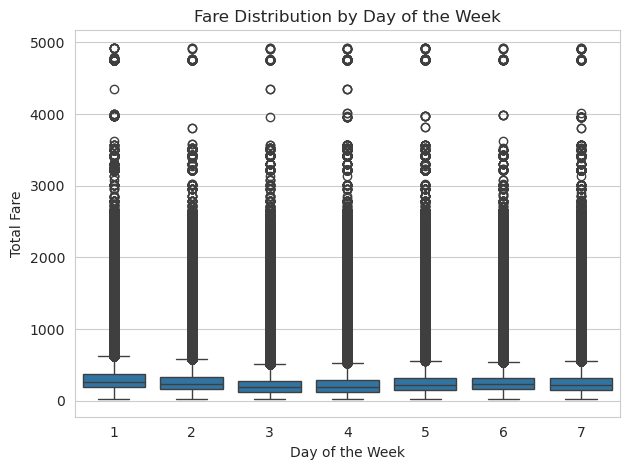

In [17]:
# Convert to pandas for visualization
day_of_week_df = sdf_cleaned.select("FlightDayOfWeek", "totalFare").toPandas()

sns.boxplot(data=day_of_week_df, x="FlightDayOfWeek", y="totalFare")
plt.title("Fare Distribution by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Fare")
plt.tight_layout()
plt.show()